In [1]:
import pandas as pd
import numpy as np
import os
import glob
import pymatgen as mg
import plot_misc2
from shutil import copyfile

from pypif import pif
from pypif.obj import *
from citrination_client import CitrinationClient
import matplotlib.pyplot as plt

from calc_chemfeat import perovskite
import warnings


In [2]:
pif

<module 'pypif.pif' from 'C:\\Users\\jdh10\\Anaconda3\\lib\\site-packages\\pypif\\pif.py'>

In [12]:
# %load_ext autoreload
# %autoreload 2
os.chdir(os.path.join(tcodir,'scripts/EIS_analysis'))
from calc_chemfeat import perovskite

## Data load process

In [2]:
def get_file_info(file,sample):
#     sampledir = os.path.join(datadir,sample)
#     os.chdir(sampledir)
    infostr = file.replace(sample,'').replace('.txt','').strip('_')
    info = infostr.split('_')
    return info

def sampledir(sample,src):
    return os.path.join(datadir,src,sample)

def get_all_conditions(sample,src):
    orig = os.getcwd()
    os.chdir(sampledir(sample,src=src))
    conditions = []
    for file in glob.glob('*.txt'):
        info = get_file_info(file,sample)
        cond = info[-2:]
        conditions.append(cond)
    
    os.chdir(orig) #return to original directory
    return np.unique(conditions,axis=0)

def load_condition_files(sample,src,condition,append_cond=False):
    orig = os.getcwd()
    os.chdir(sampledir(sample,src=src))
    cond_str = '_'.join(condition) + '.txt'
    df = pd.DataFrame()
    for file in glob.glob('*' + cond_str):
        tdf = pd.read_csv(file,sep='\t',index_col=0)
        df = df.join(tdf,how='outer')
    if append_cond==True:
        df.loc[:,'T_set'] = condition[0]
        df.loc[:,'Atmosphere'] = condition[1].lower()
        #move point to a column and make composite index
        df.loc[:,'Point'] = df.index
        df.index = df.index.astype(str) + '_' + df.T_set + '_' + df.Atmosphere
        df.index.rename('Point_condition',inplace=True)
    
    os.chdir(orig) #return to original directory
    return df

def copy_compfiles(sample,srccond,dstcond): #create missing composition files
    #within a sample, composition is same for all conditions. 
    #Copy src conditon composition files
    orig = os.getcwd()
    os.chdir(sampledir(sample))
    elements = ['Ba','Co','Fe','Y','Zr']
    for el in elements:
        srcname = '_'.join([sample,el,'at',srccond]) + '.txt'
        dstname = srcname.replace(srccond,dstcond)
        copyfile(srcname,dstname)
        print('Copied {} to {}'.format(srcname,dstname))
    
    os.chdir(orig) #return to original directory

def concat_nameswvalues(df,cols=None,roundvals=False):
    tdf = df.copy()
    if cols==None:
        cols = tdf.columns
    if roundvals!=False:
        tdf = tdf.round(roundvals)
    for col in cols:
        tdf[col] = col + tdf[col].astype(str)
    tdf['concat'] = tdf.apply(lambda x: ''.join(x),axis=1)
    return tdf['concat']

def get_formula(df,overwrite=False):
    #list all possible A and B site elements
    Asite = ['Ba']
    Bsite = ['Co','Fe','Y','Zr']

    #get elements actually present
    at_col = df.columns[df.columns.str.contains('_at')]
    el_col = at_col.str.replace('_at','')
    A_col = np.intersect1d(el_col,Asite)
    B_col = np.intersect1d(el_col,Bsite)
    if len(A_col) + len(B_col) < len(el_col):
        raise Exception('Not all elements are captured in A- and B-site lists')

    comp = df.loc[:,at_col]
    coldict = dict(zip(at_col,el_col))
    comp.rename(columns=coldict,inplace=True) #remove _at from column names
    
    #normalize for higher-occupancy site - assume other site is deficient
    sites = pd.DataFrame()
    sites['A_sum'] = comp[A_col].sum(axis=1)
    sites['B_sum'] = comp[B_col].sum(axis=1)
    sites['sitemax'] = sites.max(axis=1)
    sites['sitesum'] = sites['A_sum'] + sites['B_sum']
    badsum = sites[sites['sitesum'].round(5)!=1].index
    if len(badsum)>0:
        raise Exception('Atomic fractions do not sum to 1 for following points: {}'.format(badsum.values))
    normcomp = comp.divide(sites['sitemax'],axis=0)

    #concatenate elements & fractions to get formula string
    normcomp['formula'] = concat_nameswvalues(normcomp,roundvals=5)
    normcomp['formula'] = normcomp['formula'] + 'O3'
    
    if overwrite==False:
        return normcomp['formula']
    elif overwrite==True:
        df['formula'] = normcomp['formula']
        df.drop(columns=at_col,inplace=True)
        
def lin_reg(x,y):
    #y = mx + b
    model, resid = np.polyfit(x,y,deg=1,full=True)[:2]
    if len(x) > 2:
        R2 = float(1-resid/(y.size*y.var())) #calculate R^2
    elif len(x)==2:
        R2 = 1.5
    m = model[0]
    b = model[1]
    return m, b, R2
        
def fit_by_group(df, x, y, groupby):
    cdf = df.copy()
    fit = pd.DataFrame()
    cdf['x'] = x
    cdf['y'] = y
    cdf = cdf.loc[(pd.isnull(cdf['x'])==False) & (pd.isnull(cdf['y'])==False),:]
    grouped = cdf.groupby(groupby)
    for name, group in grouped:
        gdf = grouped.get_group(name)
        if len(gdf) > 1:
            x = np.array(gdf['x'])
            y = np.array(gdf['y']) 
            m, b, R2 = lin_reg(x,y)
            #include columns grouped by
            row = pd.Series(name, index=groupby)
            row = row.append(pd.Series([m,b,R2], index=['m','b','R2']))
            fit = fit.append(row, ignore_index=True)
            #print('Group {} fitted with {} data points'.format(name,len(gdf)))
            if len(x)==2:
                warnings.warn('Group {} fitted with only 2 data points. R^2 set to 1.5 to flag'.format(name))
        else:
            print('Group {} has too few points to fit'.format(name))
        
    return fit

def load_sample(sample,src):
    '''
    Loads all files for sample into DataFrame
    '''
    T_order = {'300C':1,'400C':2,'500C':3,'401C':4,'301C':5} #map tempId to order
    T_act = {'300C':265,'400C':351,'500C':437,'401C':351,'301C':265} #map tempId to actual temp
    
    conditions = get_all_conditions(sample,src=src)

    df = pd.DataFrame()
    for cond in conditions:
        tdf = load_condition_files(sample,src,cond,append_cond=True)
        get_formula(tdf,overwrite=True)
        #print(cond,tdf.columns)
        df = df.append(tdf,sort=True)

    df['T_order'] = df['T_set'].map(T_order)
    df['T_act'] = df['T_set'].map(T_act)
    df['T(K)'] = df['T_act'] + 273
    
    return df

def fit_df(df, min_R2=0.8, show_dist=False,show_R2=False):
    '''
    Fit ASR to Arrhenius to get slope and intercept. Resulting DataFrame has 1 row for each point
    If a single point has data for multiple conditions, conditions and properties are stored as a list
    '''
    k_B = 8.61733e-5 #Boltzmann constant in eV/K
    
    #fit each point for each atmosphere condition
    fit = fit_by_group(df,x=1/df['T(K)'],y=np.log(1/df['ASR']),groupby=['Point','formula','Atmosphere'])
    
    if show_R2==True:
        fig, ax = plt.subplots()
        grptemp = fit.groupby('Atmosphere')
        for name, group in grptemp:
            group['R2'].hist(alpha=0.5,label=name,ax=ax,grid=False,density=True)
            ax.legend()
            ax.set_title(sample)
            ax.set_xlabel('$R^2$')
            ax.set_ylabel('Density')
        ax.set_title('{} $R^2$ distribution'.format(sample))
        plt.show()
    
    init_len = len(fit)
    #remove bad data
    fit = fit.loc[fit['m']<0,:] #remove positive slopes (negative E_a)
    fit = fit.loc[fit['R2']>=min_R2] #remove fits with R^2 < threshold
    print('{}: Removed {} points out of {} with bad data'.format(sample, init_len-len(fit), init_len))

    fit['E_a'] = fit['m']*-k_B

    fit_grp = fit.groupby('Atmosphere')
    fit_agg = fit.groupby(['Point','formula']).aggregate(list)
    
    if show_dist==True:
        #check distributions
        fig, ax = plt.subplots()
        for name, group in fit_grp:
            group['E_a'].hist(alpha=0.5,label=name,ax=ax,grid=False,density=True)
            ax.legend()
            ax.set_title(sample)
            ax.set_xlabel('$E_a$ (eV)')
            ax.set_ylabel('Density')
        ax.set_title('{} $E_a$ distribution'.format(sample))
        plt.show()
            
    return fit_agg

def pif_from_fit(fit_agg,dest):
    '''
    Convert to fit_agg df to pifs. Each point has its own pif
    All pifs for sample are dumped to json file in dest directory
    ''' 
    outfile = os.path.join(dest,'{}_pif.json'.format(sample))
    file = open(outfile,'w')
    
    for i in range(len(fit_agg)):
        row = fit_agg.iloc[i,:]
        row_pif = ChemicalSystem()
        "Identifiers"
        sample_num = Id(name='Sample', value=sample[-5:])
        point = Id(name='Point',value=int(row.name[0])) #multipart index (point,formula)
        row_pif.ids = [sample_num, point]
        "Formula"
        row_pif.chemical_formula = row.name[1] #multipart index (point,formula)
        "Properties"
        #output properties - "labels"
        act_energy = Property(name='$E_a$',units='eV',scalars=row['E_a'])
        act_energy.conditions = [Value(name='Atmosphere',scalars=row['Atmosphere'])]
        props = [act_energy]
        #input propertes - "features"
        pvskt = perovskite(formula=row.name[1], site_ox_lim={'A':[2,4],'B':[3,4]},site_base_ox={'A':2,'B':4})
        pvskt.set_cat_ox_lim('Co',[2,4])
        pvskt.featurize()
        for feat, val in pvskt.features.items():
            prop = Property(name=feat,scalars=val)
            props.append(prop)
        row_pif.properties=props
        
        pif.dump(row_pif,file)
        
    file.close()    
    print('Dumped {} pifs in {}'.format(len(fit_agg), os.path.basename(outfile)))
    return outfile
    

In [3]:
tcodir = os.path.join(os.environ['HOME'],'OneDrive - Colorado School of Mines/Research/MIDDMI/TCO')
datadir = os.path.join(tcodir,'EIS_data') #data/EIS_data
pifdir = os.path.join(datadir,'pifs')

In [65]:
#copy missing composition files - only need to do once
missing_comp_samples = ['PDAC_COM3_01533','PDAC_COM3_01535','PDAC_COM3_01542','PDAC_COM3_01545']
for sample in missing_comp_samples:
    print(sample + '\n---------------------')
    copy_compfiles(sample,srccond='300C_dry',dstcond='300C_wet')

PDAC_COM3_01533
---------------------
Copied PDAC_COM3_01533_Ba_at_300C_dry.txt to PDAC_COM3_01533_Ba_at_300C_wet.txt
Copied PDAC_COM3_01533_Co_at_300C_dry.txt to PDAC_COM3_01533_Co_at_300C_wet.txt
Copied PDAC_COM3_01533_Fe_at_300C_dry.txt to PDAC_COM3_01533_Fe_at_300C_wet.txt
Copied PDAC_COM3_01533_Y_at_300C_dry.txt to PDAC_COM3_01533_Y_at_300C_wet.txt
Copied PDAC_COM3_01533_Zr_at_300C_dry.txt to PDAC_COM3_01533_Zr_at_300C_wet.txt
PDAC_COM3_01535
---------------------
Copied PDAC_COM3_01535_Ba_at_300C_dry.txt to PDAC_COM3_01535_Ba_at_300C_wet.txt
Copied PDAC_COM3_01535_Co_at_300C_dry.txt to PDAC_COM3_01535_Co_at_300C_wet.txt
Copied PDAC_COM3_01535_Fe_at_300C_dry.txt to PDAC_COM3_01535_Fe_at_300C_wet.txt
Copied PDAC_COM3_01535_Y_at_300C_dry.txt to PDAC_COM3_01535_Y_at_300C_wet.txt
Copied PDAC_COM3_01535_Zr_at_300C_dry.txt to PDAC_COM3_01535_Zr_at_300C_wet.txt
PDAC_COM3_01542
---------------------
Copied PDAC_COM3_01542_Ba_at_300C_dry.txt to PDAC_COM3_01542_Ba_at_300C_wet.txt
Copied PDA

In [22]:
"create dataset if not existing"
# client = CitrinationClient(os.environ['CITRINATION_API_KEY'],'https://citrination.com')
# dataset = client.create_dataset(name='TCO EIS data',
#                                 description='Activation energies derived from EIS data for TCO thin films',
#                                 public=0)

# dataset.id

162329

------------------
Processing PDAC_COM3_01488
------------------


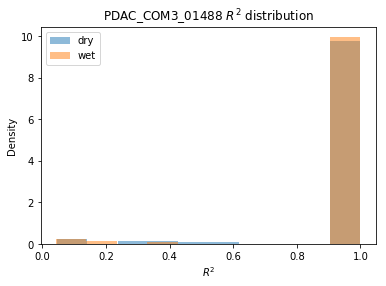

PDAC_COM3_01488: Removed 15 points out of 264 with bad data


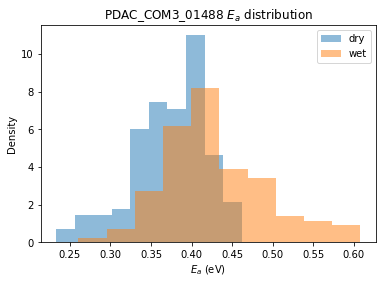

Created MPRester instance
Formation enthalpy for BaO includes data from phases: cubic, solid
Formation enthalpy for Ba includes data from phases: gas
Formation enthalpy for Co3O4 includes data from phases: cubic, solid
Formation enthalpy for Co includes data from phases: gas
Formation enthalpy for Fe2O3 includes data from phases: hemat, solid
Formation enthalpy for Fe includes data from phases: gas
Formation enthalpy for Y2O3 includes data from phases: cubic
Formation enthalpy for Y includes data from phases: gas
Formation enthalpy for ZrO2 includes data from phases: monocl
Formation enthalpy for Zr includes data from phases: gas
Dumped 131 pifs in PDAC_COM3_01488_pif.json
------------------
Processing PDAC_COM3_01533
------------------


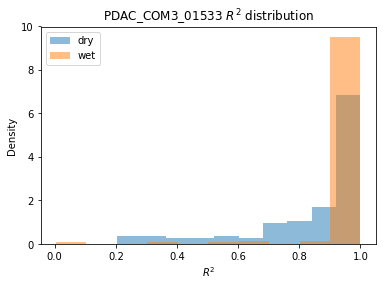

PDAC_COM3_01533: Removed 41 points out of 264 with bad data


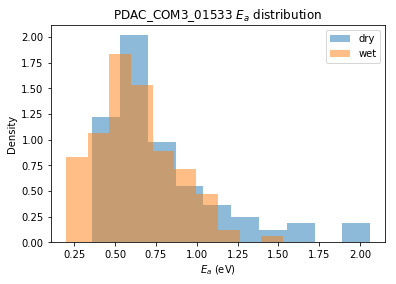

Dumped 129 pifs in PDAC_COM3_01533_pif.json
------------------
Processing PDAC_COM3_01535
------------------


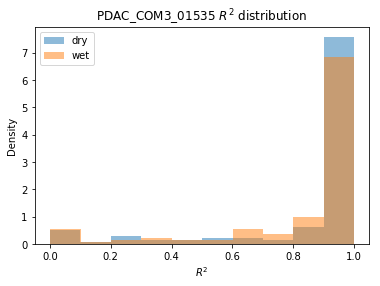

PDAC_COM3_01535: Removed 53 points out of 264 with bad data


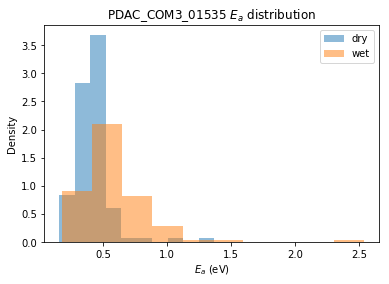

Dumped 129 pifs in PDAC_COM3_01535_pif.json
------------------
Processing PDAC_COM3_01542
------------------


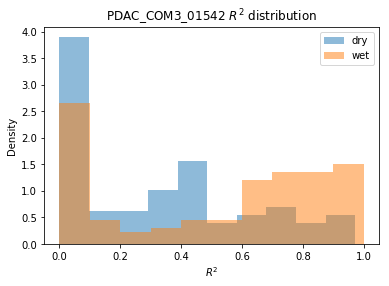

PDAC_COM3_01542: Removed 235 points out of 264 with bad data


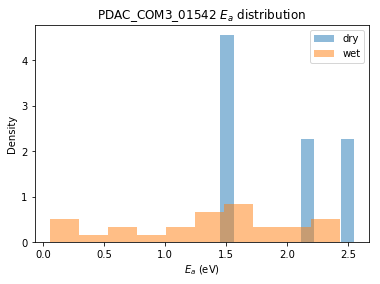

Dumped 27 pifs in PDAC_COM3_01542_pif.json
------------------
Processing PDAC_COM3_01545
------------------


C:\Users\jdhuang\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:135: UserWarning: Group (123, 'Ba0.84137Co0.02929Fe0.01492Y0.08063Zr0.87516O3', 'wet') fitted with only 2 data points. R^2 set to 1.5 to flag


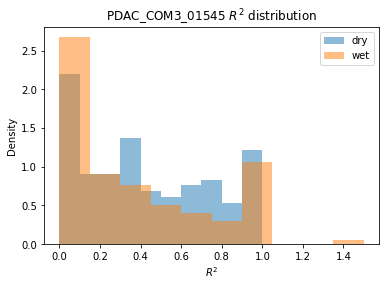

PDAC_COM3_01545: Removed 230 points out of 264 with bad data


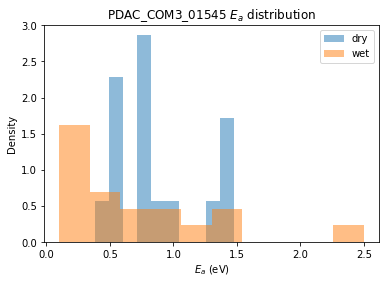

Dumped 33 pifs in PDAC_COM3_01545_pif.json
------------------
Processing PDAC_COM3_01547
------------------


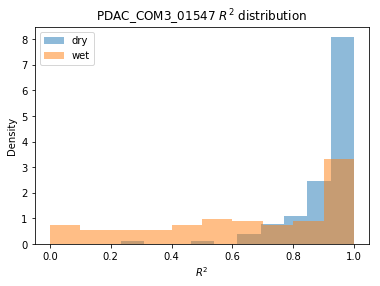

PDAC_COM3_01547: Removed 92 points out of 264 with bad data


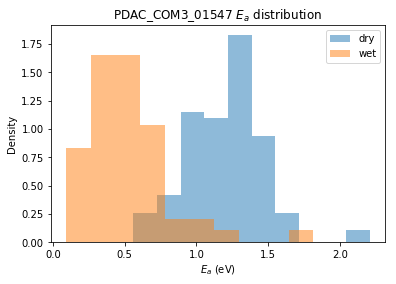

Dumped 123 pifs in PDAC_COM3_01547_pif.json
------------------
Processing PDAC_COM3_01564
------------------


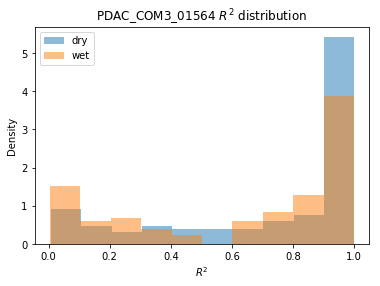

PDAC_COM3_01564: Removed 116 points out of 264 with bad data


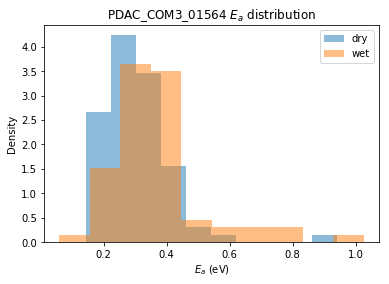

Dumped 102 pifs in PDAC_COM3_01564_pif.json
------------------
Processing PDAC_COM3_01566
------------------


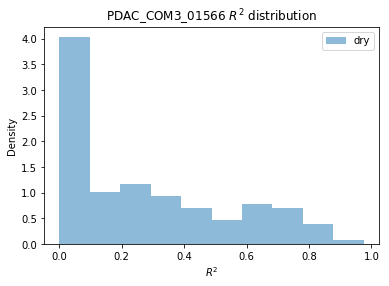

PDAC_COM3_01566: Removed 127 points out of 132 with bad data


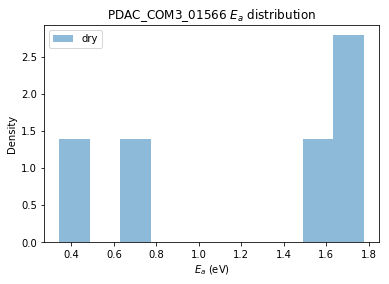

Dumped 5 pifs in PDAC_COM3_01566_pif.json
------------------
Processing PDAC_COM3_01571
------------------


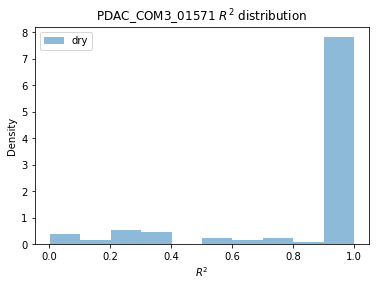

PDAC_COM3_01571: Removed 28 points out of 132 with bad data


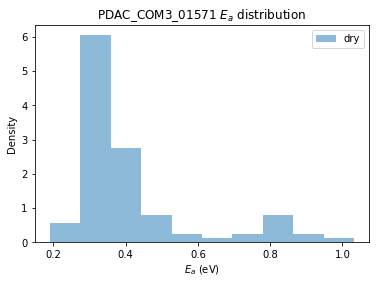

Dumped 104 pifs in PDAC_COM3_01571_pif.json


In [4]:
"Load data files and create pifs"
#ugly dict to choose which temperatures to fit for each sample
include_T_ord = {'PDAC_COM3_01542':{'wet':[3,4,5],'dry':[1,2,3,4,5]}, #missing dry 401C
                 'PDAC_COM3_01545':{'wet':[3,4,5],'dry':[1,2,3,4,5]}, #missing dry ramp down
                 'PDAC_COM3_01564':{'wet':[1,2,3],'dry':[1,2,3]}, #missing ramp down
                 'PDAC_COM3_01566':{'wet':[1,2,3,4,5],'dry':[1,2,3,4,5]} #missing ramp down for points 42-132
                }

src = 'in'
samples = next(os.walk(os.path.join(datadir,src)))[1]
outfiles = []
for sample in samples:
    print('------------------\nProcessing {}\n------------------'.format(sample))
    df = load_sample(sample,src)
    if sample in include_T_ord.keys():
        tdf = df[(df['Atmosphere']=='wet') & (df['T_order'].isin(include_T_ord[sample]['wet'])) | 
                (df['Atmosphere']=='dry') & (df['T_order'].isin(include_T_ord[sample]['dry']))]
    else:
        tdf = df[df['T_order']>=3]
    fit_agg = fit_df(tdf,min_R2=0.8,show_dist=True,show_R2=True)
    out = pif_from_fit(fit_agg,dest=pifdir)
    outfiles.append(out)
    os.rename(os.path.join(datadir,src,sample), os.path.join(datadir,'processed',sample))
    

In [5]:
"Upload pifs"
client = CitrinationClient(os.environ['CITRINATION_API_KEY'],'https://citrination.com')
dataset_id = 162329

results = []

for file in outfiles:
    result = client.upload(dataset_id,file)
    results.append(result)
    
[r.__dict__ for r in results]

[{'_failures': [],
  '_successes': [{'path': 'C:\\Users\\jdhuang\\OneDrive - Colorado School of Mines/Research/MIDDMI/TCO\\EIS_data\\pifs\\PDAC_COM3_01488_pif.json'}]},
 {'_failures': [],
  '_successes': [{'path': 'C:\\Users\\jdhuang\\OneDrive - Colorado School of Mines/Research/MIDDMI/TCO\\EIS_data\\pifs\\PDAC_COM3_01533_pif.json'}]},
 {'_failures': [],
  '_successes': [{'path': 'C:\\Users\\jdhuang\\OneDrive - Colorado School of Mines/Research/MIDDMI/TCO\\EIS_data\\pifs\\PDAC_COM3_01535_pif.json'}]},
 {'_failures': [],
  '_successes': [{'path': 'C:\\Users\\jdhuang\\OneDrive - Colorado School of Mines/Research/MIDDMI/TCO\\EIS_data\\pifs\\PDAC_COM3_01542_pif.json'}]},
 {'_failures': [],
  '_successes': [{'path': 'C:\\Users\\jdhuang\\OneDrive - Colorado School of Mines/Research/MIDDMI/TCO\\EIS_data\\pifs\\PDAC_COM3_01545_pif.json'}]},
 {'_failures': [],
  '_successes': [{'path': 'C:\\Users\\jdhuang\\OneDrive - Colorado School of Mines/Research/MIDDMI/TCO\\EIS_data\\pifs\\PDAC_COM3_01547_

## Examples of hysteresis and good/bad Arrhenius fits

Text(0.5,1,'Good fits: 01488')

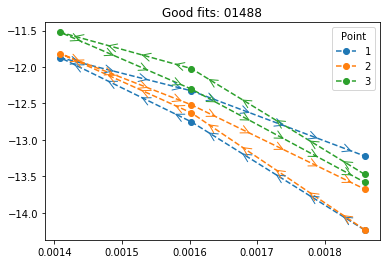

In [28]:
"Arrhenius plots of a few points in a well-behaved library"
df = load_sample('PDAC_COM3_01488',src='Samples')
df['x'] = 1/df['T(K)']
df['y'] = np.log(1/df['ASR'])
df.sort_values(by=['Point','Atmosphere','T_order'],inplace=True)
dry = df[df['Atmosphere']=='dry']
for i in range(1,4):
    ptdf = dry[dry['Point']==i]
    p = plt.plot(ptdf.x,ptdf.y,ls='--',marker='o',label=i)
    plot_misc2.add_arrows(p,xint=0.00005,size=20)
plt.legend(title='Point')
plt.title('Good fits: 01488')


Text(0.5,1,'Bad fits: 01542')

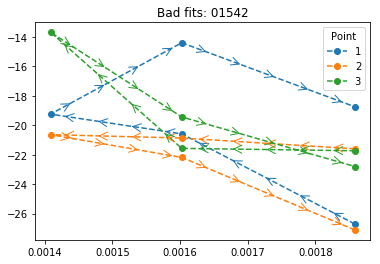

In [29]:
"Arrhenius plots of a few points in a poorly-behaved library"
df = load_sample('PDAC_COM3_01542',src='Samples')
df['x'] = 1/df['T(K)']
df['y'] = np.log(1/df['ASR'])
df.sort_values(by=['Point','Atmosphere','T_order'],inplace=True)
dry = df[df['Atmosphere']=='dry']
for i in range(1,4):
    ptdf = dry[dry['Point']==i]
    p = plt.plot(ptdf.x,ptdf.y,ls='--',marker='o',label=i)
    plot_misc2.add_arrows(p,xint=0.00005,size=20)
plt.legend(title='Point')
plt.title('Bad fits: 01542')